This notebook was run in Google Colab in order to use NumPyro.

In [18]:
!wget https://data.nasa.gov/download/vjv9-9f3x/application%2Fzip -O mill.zip
!unzip mill.zip

--2023-04-28 15:36:17--  https://data.nasa.gov/download/vjv9-9f3x/application%2Fzip
Resolving data.nasa.gov (data.nasa.gov)... 128.102.186.77, 2001:4d0:6311:2c05:60b0:5ad8:1210:ea07
Connecting to data.nasa.gov (data.nasa.gov)|128.102.186.77|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.nasa.gov/api/views/vjv9-9f3x/files/d1c796e8-ca19-4b3d-804d-845e81c7cce3?filename=mill.zip [following]
--2023-04-28 15:36:18--  https://data.nasa.gov/api/views/vjv9-9f3x/files/d1c796e8-ca19-4b3d-804d-845e81c7cce3?filename=mill.zip
Reusing existing connection to data.nasa.gov:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘mill.zip’

mill.zip                [     <=>            ]  14.44M  14.7MB/s    in 1.0s    

2023-04-28 15:36:19 (14.7 MB/s) - ‘mill.zip’ saved [15140674]

Archive:  mill.zip
  inflating: Readme.pdf              
  inflating: mill.mat                


In [141]:
from numpy.lib import npyio
import argparse
import time
from typing import Dict, Optional, Union, Sequence

import jax
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from scipy.io import loadmat
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from numpyro.infer import MCMC, NUTS


def load_milling_data(file_path: str) -> Sequence[np.ndarray]:
    """Loads the milling data.

    Args:
        file_path: The path to the milling .mat file

    Returns:
        A list of numpy arrays of the run data.
    """
    data = loadmat(file_path)
    flank_wear = data["mill"]["VB"][0].astype(float)
    case_i = data["mill"]["case"][0].astype(int)
    case_wear = [flank_wear[case_i == i] for i in np.unique(case_i)]
    for i, x in enumerate(case_wear):
        idx = np.arange(x.shape[0])
        case_wear[i] = np.interp(idx, idx[~np.isnan(x)], x[~np.isnan(x)])
    return case_wear

def stepwise_model(
    sim_steps: int,
    a: np.ndarray,
    b: np.ndarray,
    k0: int = 0,
    x0: Optional[Union[np.ndarray, float]] = 0.0,
) -> jnp.ndarray:
    sim = jnp.zeros((a.shape[0], sim_steps))
    if x0 is not None:
        sim = sim.at[:, 0].set(x0)
    for i in range(sim_steps - 1):
        k = k0 + i
        rate = 0.4 * b * jnp.exp(0.4 * a * k)
        sim = sim.at[:, i + 1].set(sim[:, i] + rate.squeeze())
    if x0 is not None:
        sim = sim.at[:, 0].set(x0)
    return sim

def mcmc_model(data: np.ndarray, sigma: float) -> torch.Tensor:
    """The model for MCMC.

    Args:
        data: The tensor of observations.
        sigma: The measurement noise.

    Returns:
        The sampled observation.
    """
    a = numpyro.sample("a", dist.Normal(0, 0.3))
    b = numpyro.sample("b", dist.HalfNormal(0.3))
    out = stepwise_model(data.shape[0], jnp.array([a]), jnp.array([b]))[0]

    return numpyro.sample("obs", dist.Normal(out, sigma), obs=data)


def plot_prognosis(
    case_data: np.ndarray, 
    obs_len: int, 
    a_samples: np.ndarray,
    b_samples: np.ndarray,
    title: str,
    ax: Optional[Axes] = None
) -> Figure:
    """Plot the prognosis.

    Args:
        case_data: The full tool wear degradation curve.
        obs_len: The length of the observation before prognosis.
        mcmc_samples: The parameter samples.
    """
    obs = case_data[:obs_len]
    all_sims = stepwise_model(
        case_data.shape[-1] - obs_len + 1,
        a_samples,
        b_samples,
        obs_len - 1,
        obs[obs_len - 1],
    )
    x = torch.arange(all_sims.shape[-1]) + obs_len - 1

    # Compute the 90-10 interval for the prognosis
    top90 = np.quantile(all_sims, 0.9, axis=0)
    bottom10 = np.quantile(all_sims, 0.1, axis=0)
    median = np.quantile(all_sims, 0.5, axis=0)

    # Compute the RMSE
    rmse = np.sqrt(((case_data[obs_len:] - median[1:]) ** 2).mean()).item()

    if ax is None:
        _, ax = plt.subplots(dpi=150)

    # ax.plot(x, all_sims[:500].T, color="b", alpha=0.1)
    ax.plot(case_data, label="Actual", color="r", marker="o", markersize=2)
    ax.plot(
        x,
        top90,
        color="b",
        ls="--",
    )
    ax.plot(x, median, color="b", ls=":", label="Median")
    ax.plot(
        x,
        bottom10,
        color="b",
        ls="--",
    )
    ax.set_ylim(0, None)
    ax.set_xlim(0, case_data.shape[0] - 1)
    ax.set_xlabel("Run Index")
    ax.set_ylabel("Flank Wear (mm)")
    ax.set_xticks(np.arange(case_data.shape[0], step=4))
    ax.set_title(title)
    ax.text(0.03, 0.85, f"RMSE = {rmse:.3f} mm", transform=ax.transAxes)

def mcmc_main(
    milling_data: str,
    case_idx: int,
    obs_len: int,
    num_samples: int,
    out_file: Optional[str] = None,
) -> Dict[str, np.ndarray]:
    """MCMC inference on milling tool wear data.

    Args:
        milling_data: Path to the milling data .mat file.
        case_idx: The index of the milling case to use.
        obs_len: The length of the observation before prognosis.
        num_samples: The number of MCMC parameter samples after warmup.
        out_file: The output .pt file for saving MCMC samples.

    Returns:
        The MCMC samples.
    """
    print(f"DEVICE == {DEVICE.type}")
    data = load_milling_data(milling_data)

    case_data = data[case_idx]
    observed_data = case_data[:obs_len]

    _, ax = plt.subplots()
    ax.plot(case_data, color="forestgreen", marker="o", markerfacecolor="white")
    ax.plot(
        observed_data, color="dodgerblue", marker="o", markerfacecolor="white", lw=2
    )
    ax.set_xlim(0, case_data.shape[0])
    ax.set_ylim(0, 1.6)
    ax.grid()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_title(f"Case {case_idx+1}")
    ax.set_xlabel("Run Index")
    ax.set_ylabel("Flank Wear (mm)")
    plt.show()

    nuts_kernel = NUTS(mcmc_model)
    mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=2000, num_chains=1)

    tic = time.perf_counter()
    # The args match those of the model function
    mcmc.run(jax.random.PRNGKey(42), observed_data, np.sqrt(0.002))
    toc = time.perf_counter()
    print(f"{toc - tic:.3f} s")

    mcmc.print_summary()

    samples: Optional[Dict[str, np.ndarray]] = mcmc.get_samples()
    assert samples is not None

    if out_file is not None:
        samples["_data"] = case_data
        samples["_obs_len"] = obs_len
        samples["_case_idx"] = case_idx
        jnp.save(out_file, samples)

    return samples, toc - tic


def show_mcmc_results(results_file: str, ax: Optional[Axes] = None):
    """Show the MCMC samples.

    Args:
        results_file: The .pt file of MCMC results.
    """
    results = np.load(results_file, allow_pickle=True).item()
    case_data = results["_data"]

    plot_prognosis(
        case_data, 
        results["_obs_len"],
        results["a"], 
        results["b"], 
        f'Case {results["_case_idx"]+1}',
        ax
    )

DEVICE == cpu


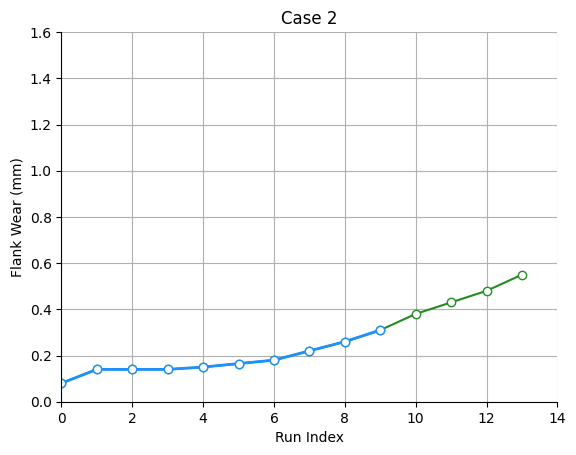

sample: 100%|██████████| 12000/12000 [00:12<00:00, 939.55it/s, 11 steps of size 2.17e-01. acc. prob=0.95] 


13.149 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.63      0.04   2216.04      1.00
         b      0.12      0.03      0.12      0.08      0.16   2205.48      1.00

Number of divergences: 0
DEVICE == cpu


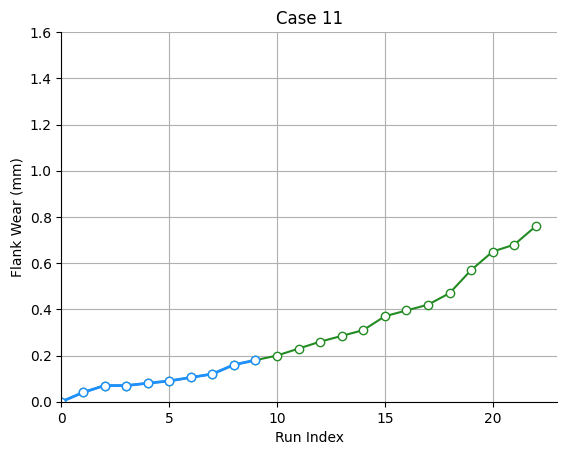

sample: 100%|██████████| 12000/12000 [00:11<00:00, 1088.22it/s, 7 steps of size 3.27e-01. acc. prob=0.91]


11.400 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.12      0.24     -0.11     -0.50      0.29   2278.13      1.00
         b      0.06      0.02      0.05      0.03      0.08   2339.81      1.00

Number of divergences: 0
DEVICE == cpu


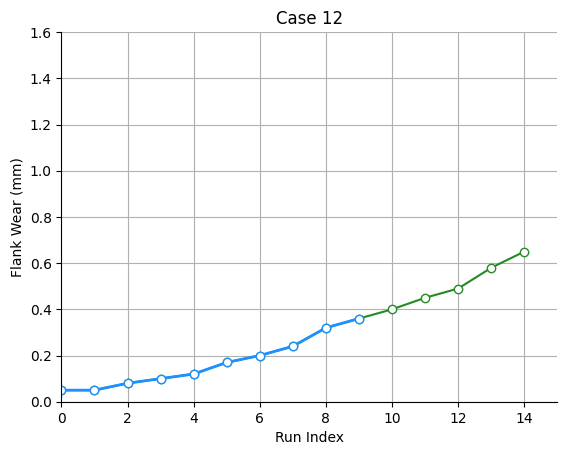

sample: 100%|██████████| 12000/12000 [00:10<00:00, 1099.08it/s, 7 steps of size 2.17e-01. acc. prob=0.94] 


11.281 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.09      0.16      0.09     -0.18      0.35   2063.09      1.00
         b      0.08      0.02      0.08      0.05      0.11   2077.95      1.00

Number of divergences: 0


In [128]:
for case_idx in [1, 10, 11]:
    _, _ = mcmc_main(
        "mill.mat", 
        case_idx=case_idx, 
        obs_len=10, 
        num_samples=10000, 
        out_file=f"case_{case_idx:02d}.npy"
    )

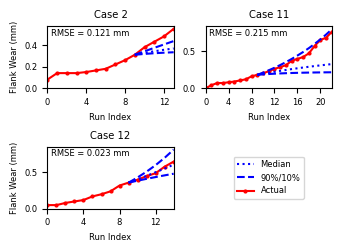

In [139]:
plt.rc("font", size=6.0)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(3.4, 2.5))
axs = [ax for row in axs for ax in row]

show_mcmc_results("case_01.npy", axs[0])
show_mcmc_results("case_10.npy", axs[1])
show_mcmc_results("case_11.npy", axs[2])
axs[1].set_ylabel("")
axs[3].axis("off")
artists = [
    plt.Line2D([], [], color="b", ls=":", label="Median"),
    plt.Line2D([], [], color="b", ls="--", label="90%/10%"),
    plt.Line2D([], [], color="r", ls="-", marker="o", markersize=2, label="Actual"),
]
plt.legend(handles=artists, loc="center")
fig.tight_layout()
plt.savefig("out.pdf", bbox_inches="tight")
plt.show()

DEVICE == cpu


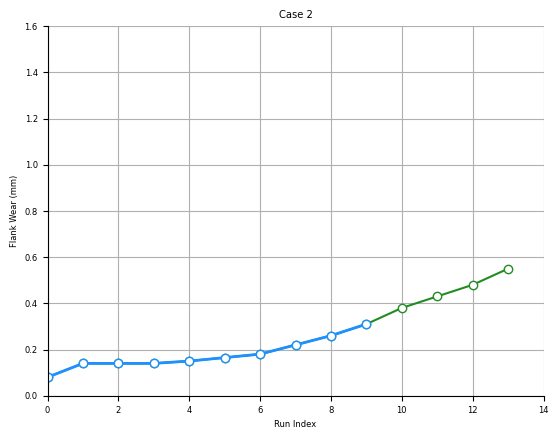

sample: 100%|██████████| 12000/12000 [00:12<00:00, 971.52it/s, 11 steps of size 2.17e-01. acc. prob=0.95]


12.750 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.63      0.04   2216.04      1.00
         b      0.12      0.03      0.12      0.08      0.16   2205.48      1.00

Number of divergences: 0
DEVICE == cpu


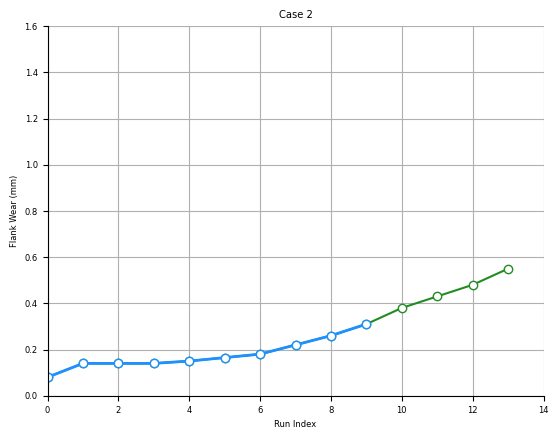

sample: 100%|██████████| 12000/12000 [00:11<00:00, 1033.50it/s, 11 steps of size 2.17e-01. acc. prob=0.95]


11.982 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.63      0.04   2216.04      1.00
         b      0.12      0.03      0.12      0.08      0.16   2205.48      1.00

Number of divergences: 0
DEVICE == cpu


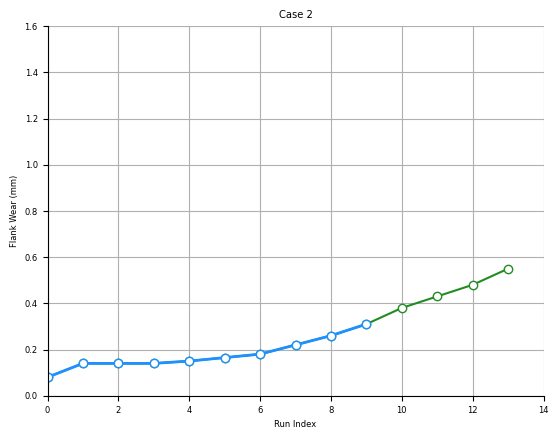

sample: 100%|██████████| 12000/12000 [00:11<00:00, 1021.92it/s, 11 steps of size 2.17e-01. acc. prob=0.95]


12.121 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.63      0.04   2216.04      1.00
         b      0.12      0.03      0.12      0.08      0.16   2205.48      1.00

Number of divergences: 0
DEVICE == cpu


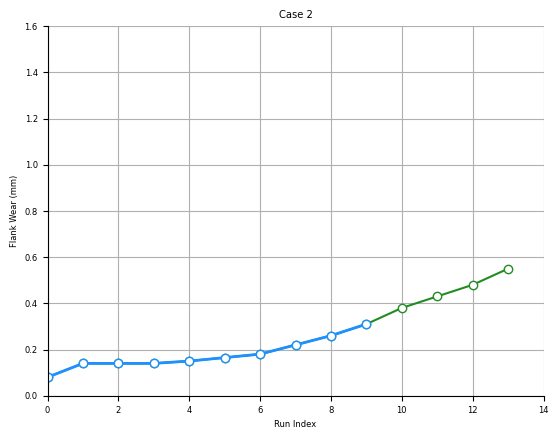

sample: 100%|██████████| 12000/12000 [00:12<00:00, 977.90it/s, 11 steps of size 2.17e-01. acc. prob=0.95]


12.679 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.63      0.04   2216.04      1.00
         b      0.12      0.03      0.12      0.08      0.16   2205.48      1.00

Number of divergences: 0
DEVICE == cpu


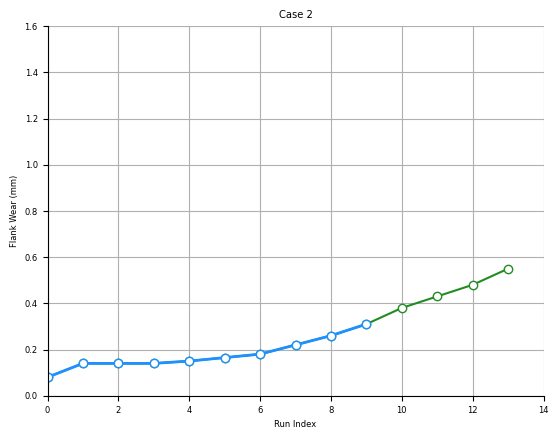

sample: 100%|██████████| 12000/12000 [00:12<00:00, 941.43it/s, 11 steps of size 2.17e-01. acc. prob=0.95] 


13.164 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.63      0.04   2216.04      1.00
         b      0.12      0.03      0.12      0.08      0.16   2205.48      1.00

Number of divergences: 0
DEVICE == cpu


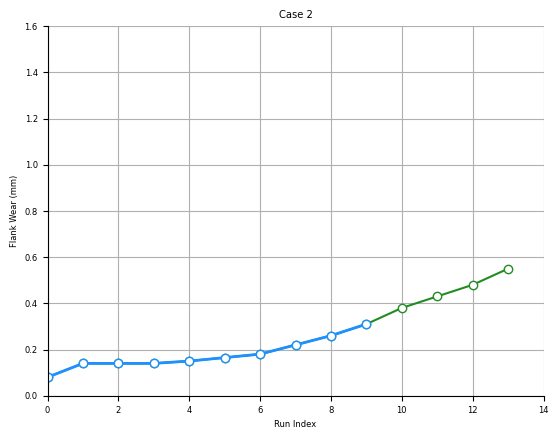

sample: 100%|██████████| 12000/12000 [00:14<00:00, 804.26it/s, 11 steps of size 2.17e-01. acc. prob=0.95]


15.425 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.63      0.04   2216.04      1.00
         b      0.12      0.03      0.12      0.08      0.16   2205.48      1.00

Number of divergences: 0
DEVICE == cpu


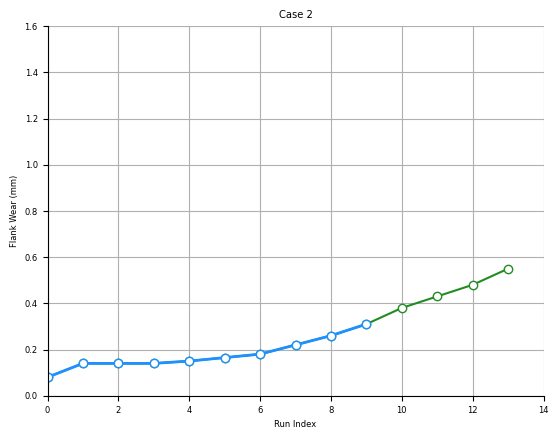

sample: 100%|██████████| 12000/12000 [00:11<00:00, 1023.13it/s, 11 steps of size 2.17e-01. acc. prob=0.95]


12.176 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.63      0.04   2216.04      1.00
         b      0.12      0.03      0.12      0.08      0.16   2205.48      1.00

Number of divergences: 0
DEVICE == cpu


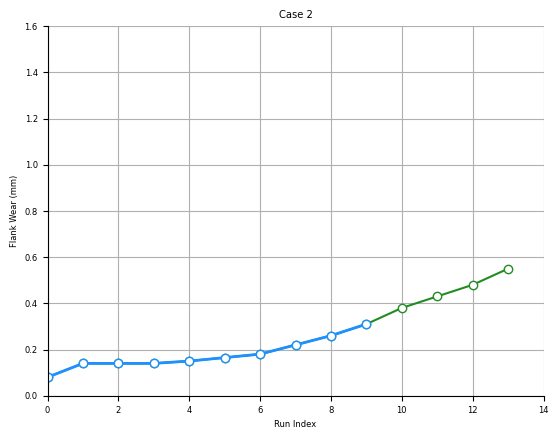

sample: 100%|██████████| 12000/12000 [00:11<00:00, 1088.49it/s, 11 steps of size 2.17e-01. acc. prob=0.95]


11.590 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.63      0.04   2216.04      1.00
         b      0.12      0.03      0.12      0.08      0.16   2205.48      1.00

Number of divergences: 0
DEVICE == cpu


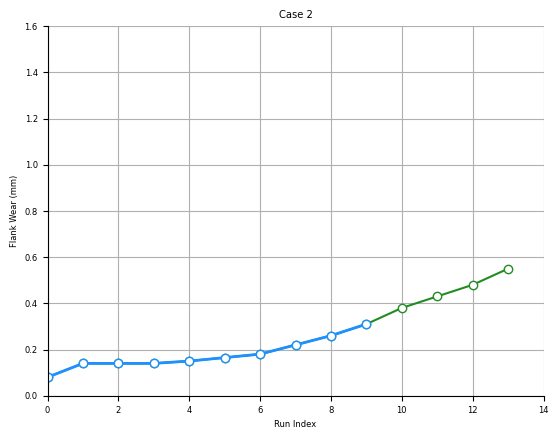

sample: 100%|██████████| 12000/12000 [00:12<00:00, 978.18it/s, 11 steps of size 2.17e-01. acc. prob=0.95]


12.816 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.63      0.04   2216.04      1.00
         b      0.12      0.03      0.12      0.08      0.16   2205.48      1.00

Number of divergences: 0
DEVICE == cpu


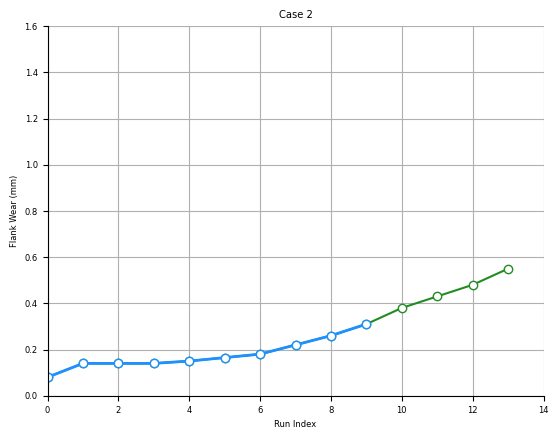

sample: 100%|██████████| 12000/12000 [00:12<00:00, 928.57it/s, 11 steps of size 2.17e-01. acc. prob=0.95] 


13.454 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.63      0.04   2216.04      1.00
         b      0.12      0.03      0.12      0.08      0.16   2205.48      1.00

Number of divergences: 0
DEVICE == cpu


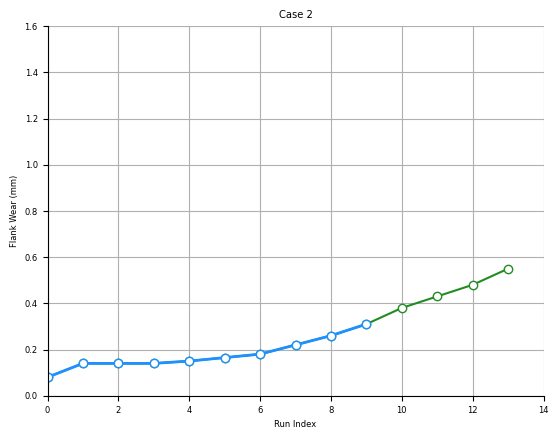

sample: 100%|██████████| 12000/12000 [00:11<00:00, 1050.39it/s, 11 steps of size 2.17e-01. acc. prob=0.95]


11.859 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.63      0.04   2216.04      1.00
         b      0.12      0.03      0.12      0.08      0.16   2205.48      1.00

Number of divergences: 0
DEVICE == cpu


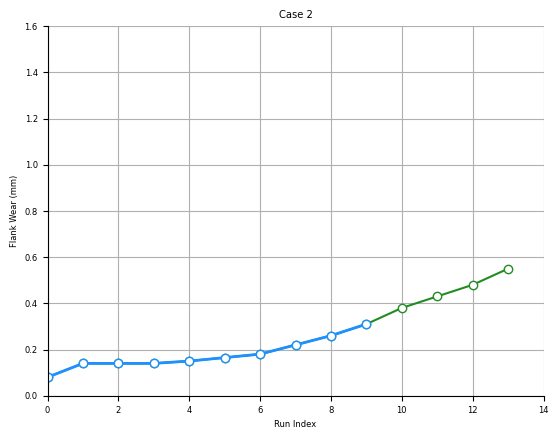

sample: 100%|██████████| 12000/12000 [00:11<00:00, 1023.94it/s, 11 steps of size 2.17e-01. acc. prob=0.95]


12.290 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.63      0.04   2216.04      1.00
         b      0.12      0.03      0.12      0.08      0.16   2205.48      1.00

Number of divergences: 0
DEVICE == cpu


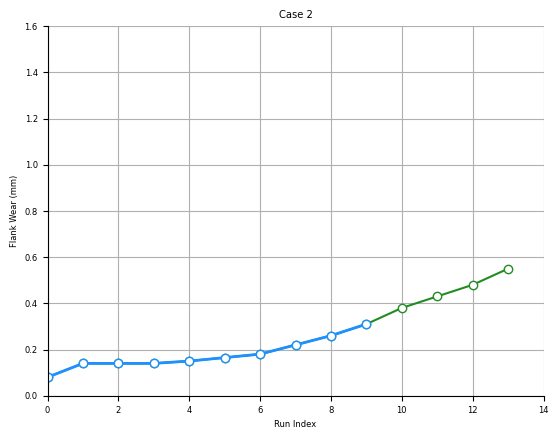

sample: 100%|██████████| 12000/12000 [00:11<00:00, 1088.00it/s, 11 steps of size 2.17e-01. acc. prob=0.95]


11.562 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.63      0.04   2216.04      1.00
         b      0.12      0.03      0.12      0.08      0.16   2205.48      1.00

Number of divergences: 0
DEVICE == cpu


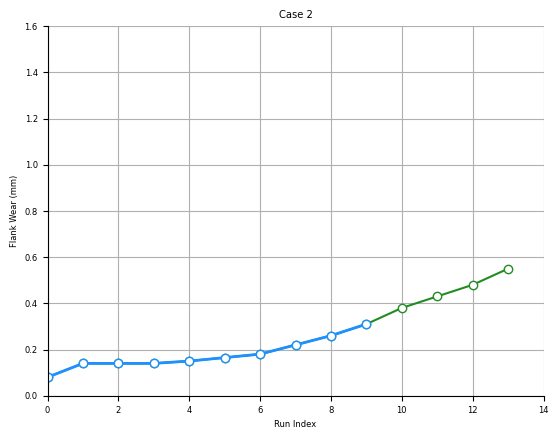

sample: 100%|██████████| 12000/12000 [00:11<00:00, 1071.81it/s, 11 steps of size 2.17e-01. acc. prob=0.95]


11.714 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.63      0.04   2216.04      1.00
         b      0.12      0.03      0.12      0.08      0.16   2205.48      1.00

Number of divergences: 0
DEVICE == cpu


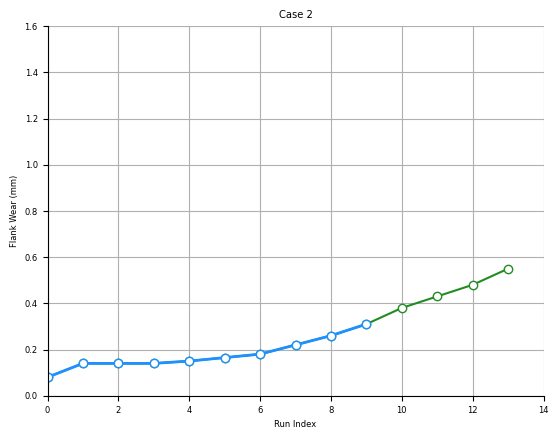

sample: 100%|██████████| 12000/12000 [00:11<00:00, 1048.02it/s, 11 steps of size 2.17e-01. acc. prob=0.95]


11.952 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.63      0.04   2216.04      1.00
         b      0.12      0.03      0.12      0.08      0.16   2205.48      1.00

Number of divergences: 0
DEVICE == cpu


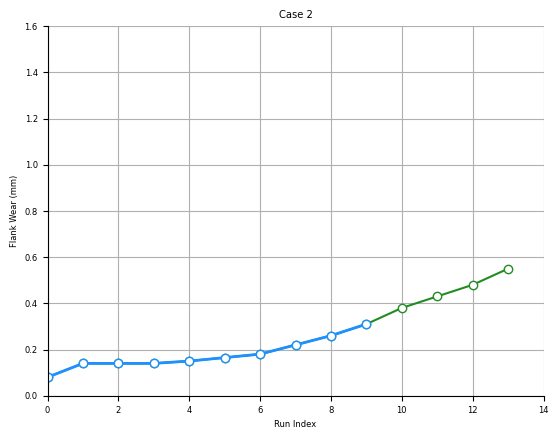

sample: 100%|██████████| 12000/12000 [00:12<00:00, 923.47it/s, 11 steps of size 2.17e-01. acc. prob=0.95] 


13.426 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.63      0.04   2216.04      1.00
         b      0.12      0.03      0.12      0.08      0.16   2205.48      1.00

Number of divergences: 0
DEVICE == cpu


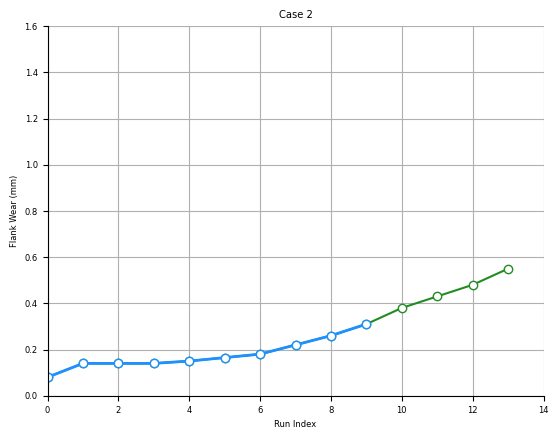

sample: 100%|██████████| 12000/12000 [00:11<00:00, 1024.92it/s, 11 steps of size 2.17e-01. acc. prob=0.95]


12.270 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.63      0.04   2216.04      1.00
         b      0.12      0.03      0.12      0.08      0.16   2205.48      1.00

Number of divergences: 0
DEVICE == cpu


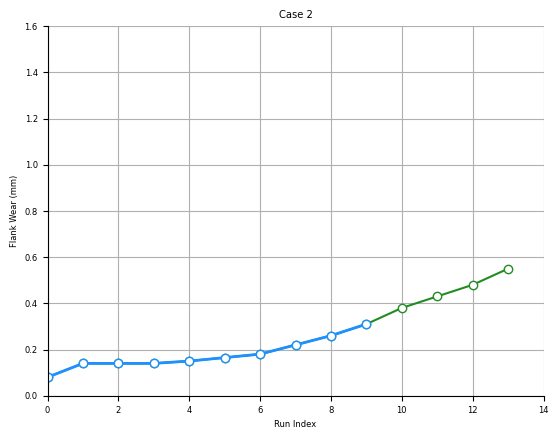

sample: 100%|██████████| 12000/12000 [00:12<00:00, 935.38it/s, 11 steps of size 2.17e-01. acc. prob=0.95]


13.352 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.63      0.04   2216.04      1.00
         b      0.12      0.03      0.12      0.08      0.16   2205.48      1.00

Number of divergences: 0
DEVICE == cpu


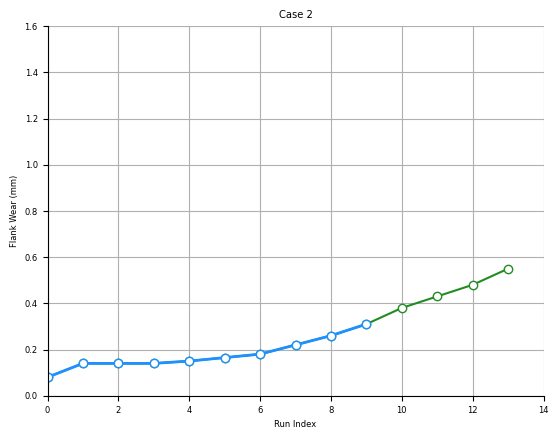

sample: 100%|██████████| 12000/12000 [00:11<00:00, 1006.61it/s, 11 steps of size 2.17e-01. acc. prob=0.95]


12.466 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.63      0.04   2216.04      1.00
         b      0.12      0.03      0.12      0.08      0.16   2205.48      1.00

Number of divergences: 0
DEVICE == cpu


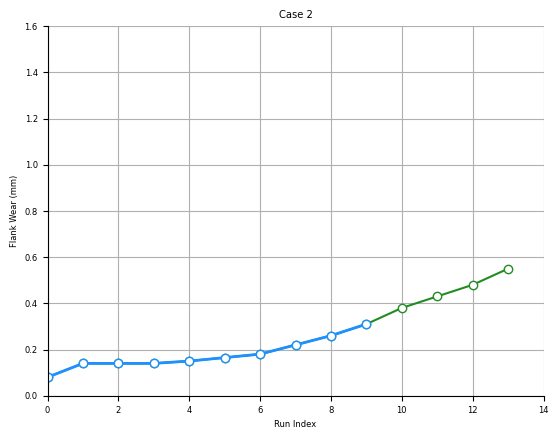

sample: 100%|██████████| 12000/12000 [00:11<00:00, 1088.96it/s, 11 steps of size 2.17e-01. acc. prob=0.95]


11.501 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.63      0.04   2216.04      1.00
         b      0.12      0.03      0.12      0.08      0.16   2205.48      1.00

Number of divergences: 0
DEVICE == cpu


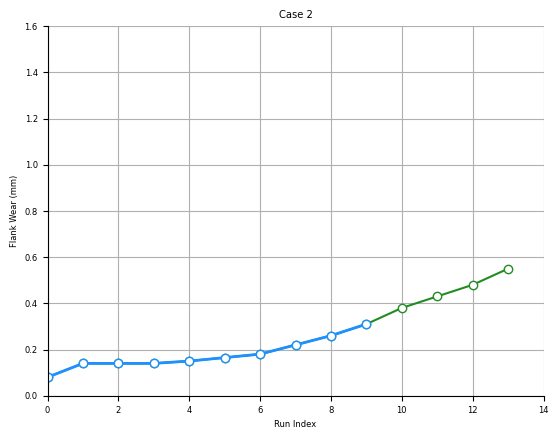

sample: 100%|██████████| 12000/12000 [00:11<00:00, 1051.90it/s, 11 steps of size 2.17e-01. acc. prob=0.95]


11.892 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.63      0.04   2216.04      1.00
         b      0.12      0.03      0.12      0.08      0.16   2205.48      1.00

Number of divergences: 0
DEVICE == cpu


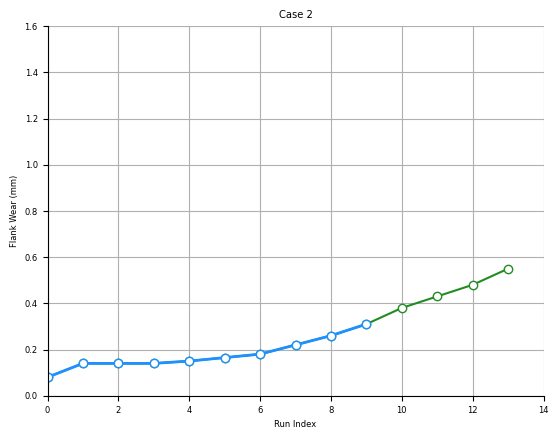

sample: 100%|██████████| 12000/12000 [00:11<00:00, 1007.78it/s, 11 steps of size 2.17e-01. acc. prob=0.95]


12.397 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.63      0.04   2216.04      1.00
         b      0.12      0.03      0.12      0.08      0.16   2205.48      1.00

Number of divergences: 0
DEVICE == cpu


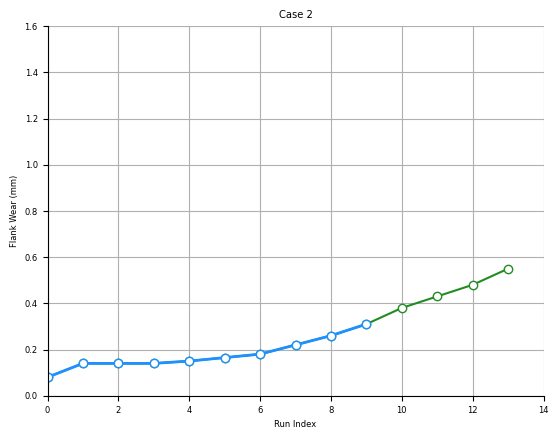

sample: 100%|██████████| 12000/12000 [00:11<00:00, 1039.57it/s, 11 steps of size 2.17e-01. acc. prob=0.95]


12.044 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.63      0.04   2216.04      1.00
         b      0.12      0.03      0.12      0.08      0.16   2205.48      1.00

Number of divergences: 0
DEVICE == cpu


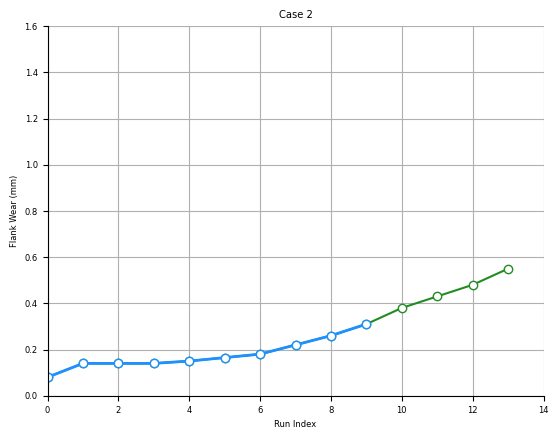

sample: 100%|██████████| 12000/12000 [00:12<00:00, 971.56it/s, 11 steps of size 2.17e-01. acc. prob=0.95] 


12.718 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.63      0.04   2216.04      1.00
         b      0.12      0.03      0.12      0.08      0.16   2205.48      1.00

Number of divergences: 0
DEVICE == cpu


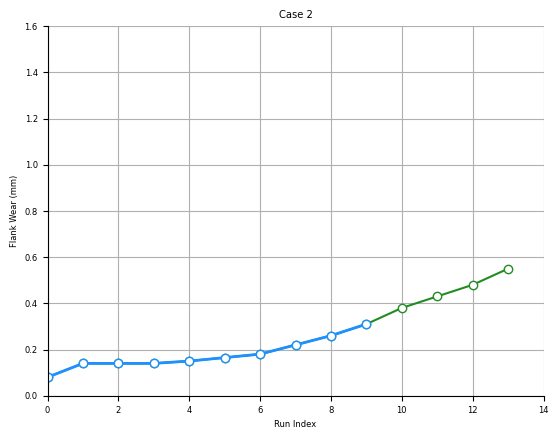

sample: 100%|██████████| 12000/12000 [00:11<00:00, 1039.45it/s, 11 steps of size 2.17e-01. acc. prob=0.95]


12.061 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.29      0.21     -0.28     -0.63      0.04   2216.04      1.00
         b      0.12      0.03      0.12      0.08      0.16   2205.48      1.00

Number of divergences: 0
12.466+/-0.828 s


In [142]:
times = []
for _ in range(25):
    _, elapsed = mcmc_main(
        "mill.mat", 
        case_idx=1, 
        obs_len=10, 
        num_samples=10000, 
        out_file=f"case_{case_idx:02d}.npy"
    )
    times.append(elapsed)
print(f"{np.mean(times):.3f}+/-{np.std(times):.3f} s")